# From Signal to Algorithm
by Christopher van Hoecke, Max Margenot and Delaney Granizo-Mackenzie

After having run extensive research on your strategy using the research environment and alphalens, it is time to test your strategy in the backtest IDE. Backtesting is the process with which quantitative traders test their strategies after having found an alpha generating factor in the research environment, and tested its feasibility using alphalens. Once constructed, the backtest simulates a strategy’s performance based on relevant historic data, to ensure it performs as expected when taking real market parameters such as slippage and commissions into account. While backtesting can give us great insight into how our strategy would have performed, it is important to keep in mind that past performance is not indicative of future ones. Nevertheless, good backtesting practices helps in extracting a deeper understanding of how our strategy will react to market behaviors.  In this lecture, we go over the steps towards constructing a successful backtest, and what to be cautious about. 

## Portfolio Construction
The portfolio construction is one of two things to look out for prior to launching a backtest. *We go over Best Code practices bellow.* Portfolio construction can be summarized by two main branches, optimizing the universe construction and position concentration.

### Defining a trading universe
As described by Quantopian's CIO Jonathan Larkins in his [post](https://blog.quantopian.com/a-professional-quant-equity-workflow/) *A Professional Quant Equity Workflow*, the first step towards developing a successful trading strategy is defining a good universe. The reasons for this are multiple as explained in the post. However, we will only concern ourselves with thinking about the liquidity of an asset for now. Liquidity of an asset refers to how easily it can be converted to cash and how much of an impact the transaction will have on the asset's price. An asset on the NYSE that is illiquid is one that is not frequently traded, and who's price will therefore shift drastically in the event of a sale or purchase. Consequently, the presence of illiquid assets in your universe will have dire consequences on your trading strategy as the purchase and sale of these assets will spike the price up or down, increasing slippage, therefore increasing the percentage of returns being sacrificed in the transaction.

You can protect against illiquidity in your universe by checking the volume associated with the assets in your trading. An asset with high volume is often exchanged, making it easier to find potential buyers and sellers for it. While you can construct your own liquid universe using the ` make_us_equity_universe`, picking from one of the predefined Q universes. *You can read more about both [here](https://www.quantopian.com/posts/the-q500us-and-q1500us)*. To illustrate the value of a good universe, we generate alphalens plots of the same momentum factor, during the same period, but with different universes (one uses the Q1500US, while the other does not filter its universe).

In [2]:
# Importing useful libraries
import matplotlib.pyplot as plt
import numpy as np

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.filters import Q1500US
from quantopian.pipeline.classifiers.fundamentals import Sector

import alphalens as al
import pyfolio as pf

We begin by constructing a CustomFactor. We choose to use the momentum factor, implemented in the Lecture Sample: Long-Short Equity, available [here](https://www.quantopian.com/lectures/example-long-short-equity-algorithm). We run pipeline twice, once using a screen to filter out assets that are not in the Q1500, and another with no screen. We then use `alphalens` to get the cumulative returns of our strategy in the period from 2015 to 2016.   
*You can read about alphalens and factor analysis [here](https://www.quantopian.com/lectures/factor-analysis).*

In [3]:
# Define a Momentum factor. 
class Momentum(CustomFactor):
        inputs = [USEquityPricing.close,
                  Returns(window_length=126)]
        window_length = 252
        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-252])/prices[-252] - \
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
        

# Running pipeline with and without the Q1500 universe screen. 
with_universe = Pipeline(columns = {'Momentum ' : Momentum()}, screen = Q1500US())
without_universe = Pipeline(columns = {'Momentum' : Momentum()}, screen = ~Q1500US())

with_universe_results = run_pipeline(with_universe, '2015-01-01', '2016-01-01')
without_universe_results = run_pipeline(without_universe, '2015-01-01', '2016-01-01')

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [4]:
# Getting clean factor and forward returns for pipeline WITH Q1500 screen
with_clean = al.utils.get_clean_factor_and_forward_returns(
                                             factor = with_universe_results, 
                                             prices = get_pricing(with_universe_results.index.levels[1],
                                                                 start_date = '2015-01-01',
                                                                 end_date = '2016-01-01',
                                                                  fields = 'price'))
with_ls_factor_returns = al.performance.factor_returns(with_clean)

# Getting clean factor and forward returns for pipeline WITHOUT Q1500 screen. 
without_clean = al.utils.get_clean_factor_and_forward_returns(
                                             factor = without_universe_results, 
                                             prices = get_pricing(without_universe_results.index.levels[1],
                                                                 start_date = '2015-01-01',
                                                                 end_date = '2016-01-01',
                                                                  fields = 'price'))
without_ls_factor_returns = al.performance.factor_returns(without_clean)

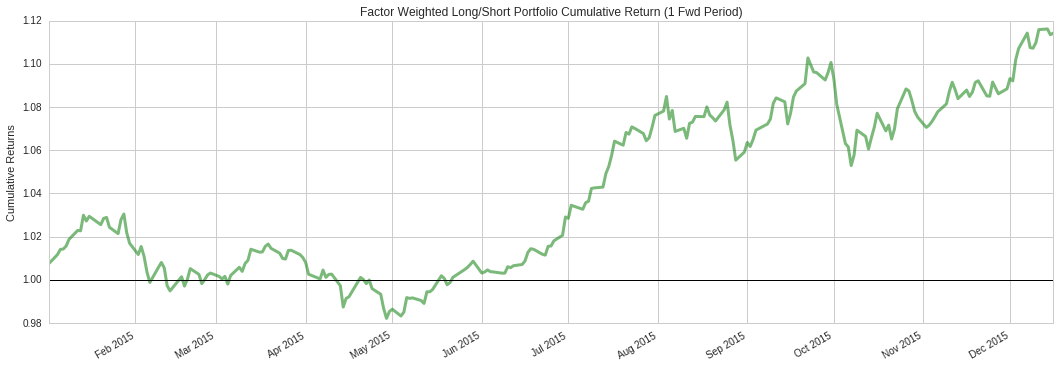

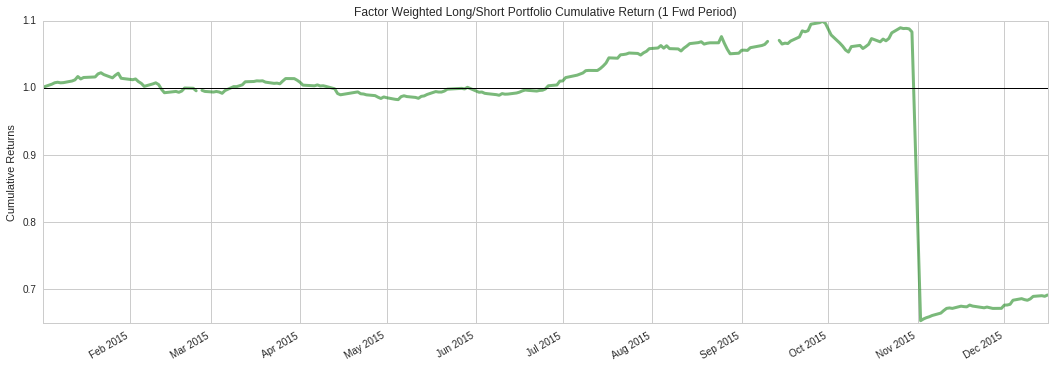

In [5]:
# Plotting mean returns by factor Quantile for factor WITH Q1500 screen
al.plotting.plot_cumulative_returns(with_ls_factor_returns[1]);

# Plotting mean returns by factor Quantile for Factor WITHOUT Q1500 screen. 
al.plotting.plot_cumulative_returns(without_ls_factor_returns[1]);

From these two outputs, we can see the importance of a good universe screen. *Note however that alphalens does **not consider slippage and commissions**. This means that the greater impact our transactions have on an asset's price are not considered in our returns. *

### Long-Short Strategy

One of the key methods towards being market independent is using a long-short strategy. This simply means that our strategy is at any given time searching for signals to both buy and short assets allowing us to significantly decrease our dependency to the market as we take positive action in the event of an expansion and a retraction. The neutrality of a long-short strategy mainly spawns from its use of a ranking scheme. After having developed a factor such as the momentum factor above we can rank factor values based on some criteria, and chose to long one basket while shorting another. We go over an example of this method bellow *If you'd like to read more about developing Long-Short equity strategies [here](https://www.quantopian.com/lectures/long-short-equity#notebook)* 

Bellow, we begin by constructing a Custom Sharpe ratio factor, defined as returns over volatility. And run pipeline to get the factor value for each asset in the Q1500 over the period from 2015 to 2016.

In [6]:
class Sharpe(CustomFactor):
    inputs = [Returns(window_length = 2)]
    window_length = 252
    def compute(self, today, assets, out, returns):
        out[:] = returns[0] / np.nanstd(returns, axis = 0)
        
pipe = Pipeline(columns = {'Sharpe' : Sharpe()}, screen = Q1500US())
results = run_pipeline(pipe, '2015-01-01', '2016-01-01')

In [7]:
results.head()

Sharpe
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.501392
                          Equity(24 [AAPL]) -1.038462
                          Equity(41 [ARCB])  0.166821
                          Equity(62 [ABT])  -0.269864
                          Equity(67 [ADSK]) -1.280121

From here, we set about ranking our factor results. Assuming we would like to long assets with high Sharpe ratio, and short those with low Sharpe ratio, we can use pandas's `.rank` function to get the respective rank of each value. We then construct two universes: 'LONG', which consists of our factors top quartile, and one we shall call 'SHORT', which consists of our factors bottom quantile. This allows us to construct two sub-universes of assets to long, and short of equal sizes, which allows us to protect against market movements. *A simpler version of this would be to simply hedge beta (ie: Only short the benchmark, which in our case would be SPY, the S&P's ETF). You can read more about that in our lecture on [beta hedging](https://www.quantopian.com/lectures/beta-hedging).*

In [8]:
# ranking our factors into long and short bins. 
results = results.rank()
top_quantil = results['Sharpe'].max() - (results['Sharpe'].max() * 25 / 100)

LONG = results[results['Sharpe'] > top_quantil] # long top quantil
SHORT = results[results['Sharpe'] < (results['Sharpe'].max() * 25 / 100)] #short bottom quantil

print 'Length of LONG:', len(LONG)
print 'Length of SHORT:', len(SHORT)

Length of LONG: 92163
Length of SHORT: 92162


### Sector Neutrality 

Alongside *beta neutrality* one of the key pillars of universe optimization involves being sector neutral. 
Monitoring your sector exposure is especially important to protect against drawdown and volatility. Sectors are especially vulnerable to exterior influence such as political regime changes, economic bubbles and others. This is especially true during the 2008 subprime mortgage debt crises, the bio-tech, and oil bubble of 2016, or even the tech-bubble of 2001. Strategies that solely relied on these sectors to make profits incurred tremendous losses once the sellout began. Protecting against such unpredictable events is the key to having consistency in your strategy.

There exists multiple way of protecting against sector dependencies, the simplest of which is using Pipeline's classifiers to make sure our universe is sector neutral. This can be done using pipeline as we show bellow. We use our Sharpe ratio factor from above and include Morningstar's sector classifier. This allows us to measure how well our factor performs in each sector and ensure we have a homogeneous performance throughout each sector. *You can read more about how to monitor for sectors using alphalens [here](https://www.quantopian.com/lectures/factor-analysis).*

Below we run pipeline with our Sharpe factor, and Sector classifier from Januray to March 2015, and define our `MORNINGSTART_SECTOR_CODES` dictionary to assign a label to each sector code.  

In [9]:
# Defining and running pipeline
pipe = Pipeline(columns = {'Sharpe':Sharpe(),
                           'Sectors' : Sector()},
               screen = Q1500US())

results = run_pipeline(pipe, '2015-01-01', '2015-05-01')

In [10]:
# Sector labels 
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

results.head()

Sectors    Sharpe
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])       101 -0.501392
                          Equity(24 [AAPL])      311 -1.038462
                          Equity(41 [ARCB])      310  0.166821
                          Equity(62 [ABT])       206 -0.269864
                          Equity(67 [ADSK])      311 -1.280121

To analyse our factor, we use `alphalens`'s `get_clean_factor_and_forward_returns` function to get our factor_data by adding the `groupby` and `groupby_labels`, to assign a sector to each value. 

In [11]:
# Defining factor_data with groupby
factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                    factor=results['Sharpe'],
                                                    prices = get_pricing(results.index.levels[1].unique(),
                                                                           start_date = '2015-01-01',
                                                                           end_date = '2015-05-01',
                                                                           fields = 'price'),
                                                    groupby=results['Sectors'],
                                                    groupby_labels=MORNINGSTAR_SECTOR_CODES
                                                           )

We can now use our `factor_data` to get our mean returns by sector, and plot them using the `plot quantile_returns_bar`. 

In [12]:
# Sector mean returns 
mean_return_quantile_sector, mean_return_quantile_sector_err = (
                                al.performance.mean_return_by_quantile(factor_data,
                                                                       by_group=True))

mean_return_quantile_sector.head()

1         5         10
factor_quantile group                                               
1               Basic Materials        -0.000929 -0.006150 -0.003587
                Communication Services -0.000109  0.003227  0.007938
                Consumer Cyclical      -0.001115 -0.001664 -0.002345
                Consumer Defensive     -0.000619 -0.001283 -0.003945
                Energy                 -0.000514  0.004112  0.010247

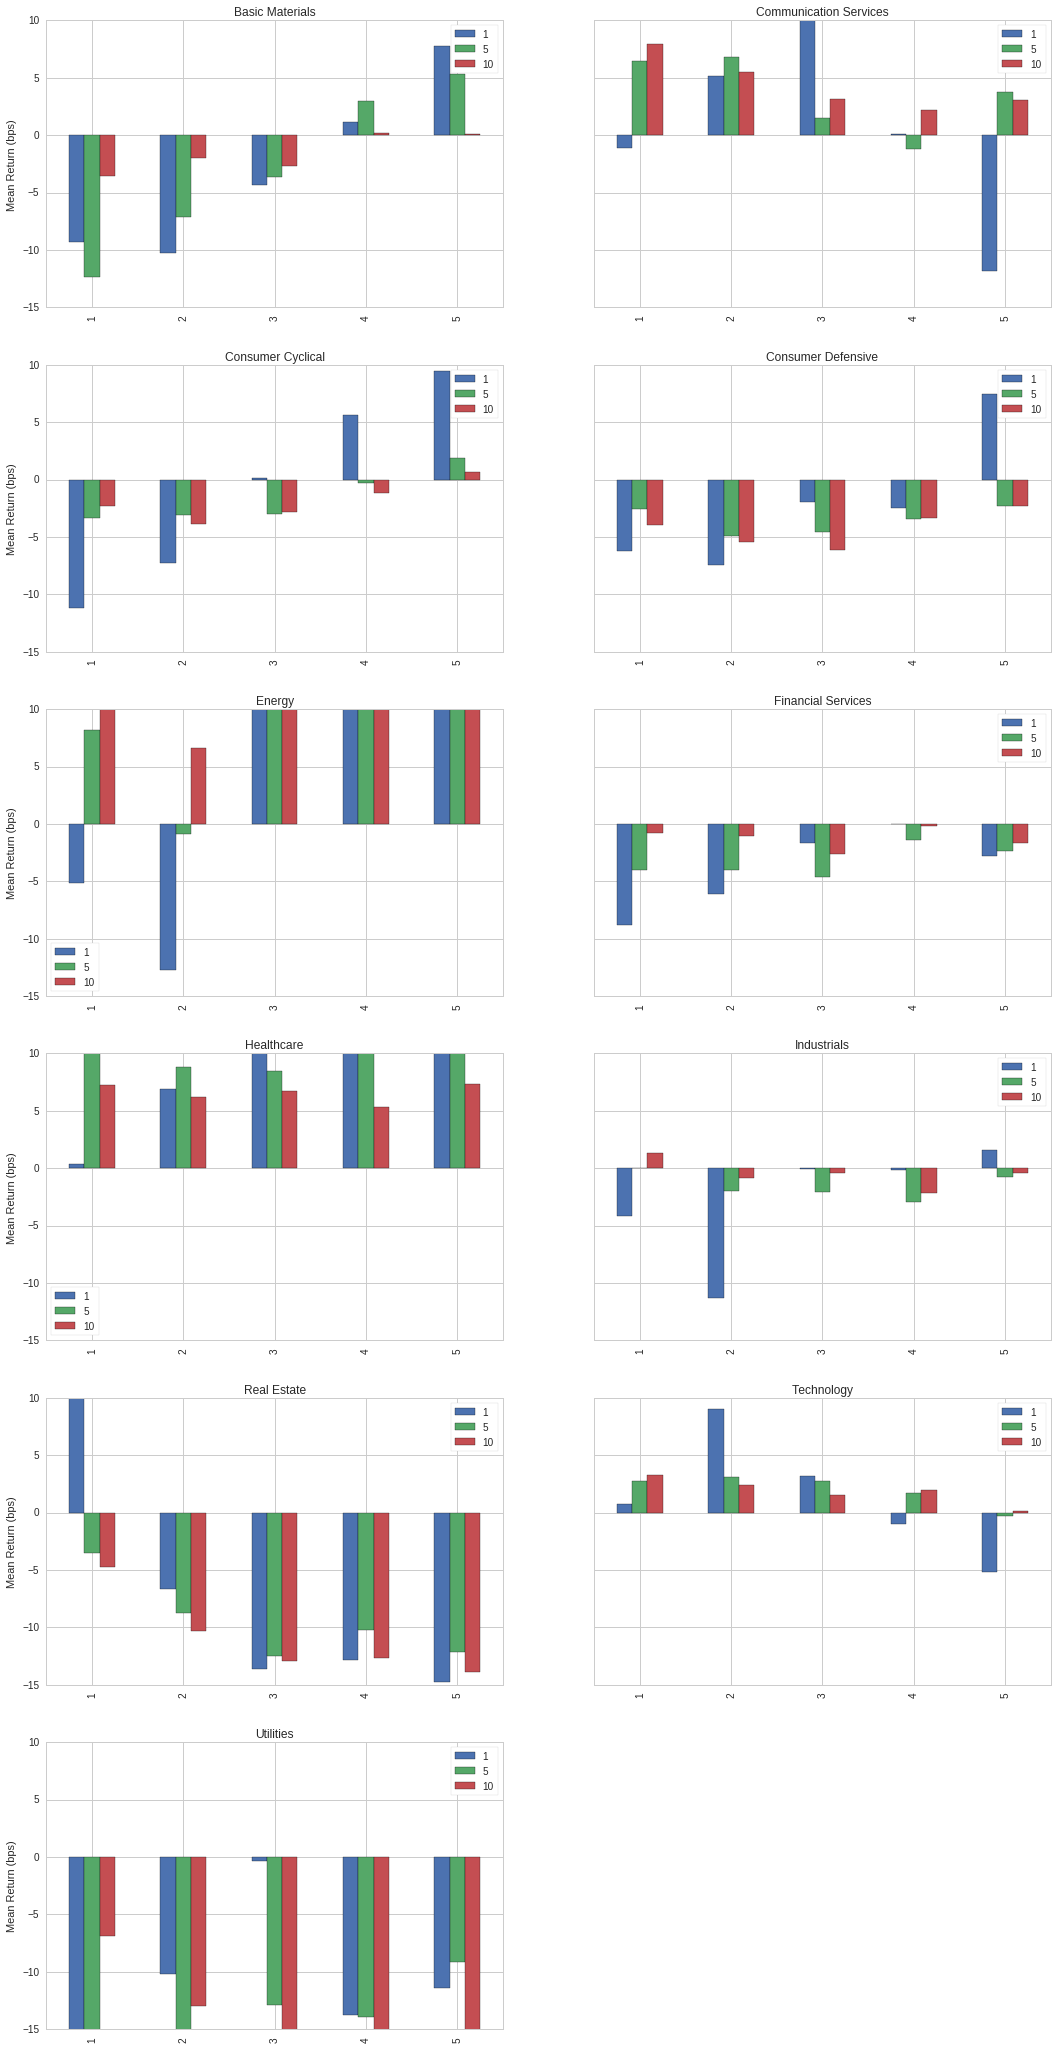

In [13]:
al.plotting.plot_quantile_returns_bar(mean_return_quantile_sector.apply(al.utils.rate_of_return, axis=0), by_group=True);

Using alphalens's `groupby` parameter we get the quantile returns grouped by sector. This allows us to see how our signal performs throughout sectors. We should use this to check for consistency throughout each sector, making sure our returns are not fueled solely by a few sectors. We can repeat the same process with the `Information Coefficient` to assess the predictive power of our factor across different sectors, again looking for homogeneity throughout each sector. You can read more about finding sector specific IC [here](https://www.quantopian.com/lectures/factor-analysis).

### Position Concentration

A key concept in finance is that of diversification. By assigning more weights on uncorrelated assets, we can simulate placing independent bets, which allows us to hedge out risk. *You can read more about position concentration [here](https://www.quantopian.com/lectures/position-concentration-risk).*

## Code practices
As mentioned above, the second important aspect of signal development is coding. A well written algorithm is one where we are aware of what is going on at all moments, and will not behave unexpectedly in the event of an anomaly. Bellow we go over a few practices to think of when developing your algorithm to make sure we're constantly aware of what's going on. To do this we split this section into two sub-sections that deal with safeguards, and precautious methods.

### Ordering
Rebalancing is one of the key moments of the backtest as it is where the buying and selling occurs. Making sure that everything runs smoothly at this stage is vital. Other than screening pipeline to filter assets in the Q1500, using functions like ```data.can_trade``` in the backtest IDE ensures we only trade assets that have not been dropped from the stock exchange. To prevent against this and ensure our strategy orders assets on a more holistic form, use the Optimize API to ensure the transactions are executed in the most effective of ways to reduce the strategies market impact, slippage and commissions. *You can read more about the order optimal API [here](https://www.quantopian.com/help#optimize-api)*

Below we go over an example of `order_optimal_portfolio`, which uses the `TargetPortfolioWeights` class which, given a desired weight will attempt to find the optimal weights associated with each asset. In our example we assign equal weights to each asset, and use the `MaxGrossLeverage` constraint to set a maximum leverage our strategy can take *(in this case it is 1x)*

In [ ]:
from quantopian.experimental import optimize as opt

# Assign desired weights in the form of a dictionary or a pandas Series. 
weights = {'AAPL':0.5, 
           'SBUX':0.5}

obj = opt.TargetPortfolioWeights(weights)
const = opt.MaxGrossLeverage(1)
opt.order_optimal_portfolio(objective = obj, 
                        constraints = const)

### Logging
The more data we can collect on our backtest, the better we can anticipate how it will perform out of sample. To do this, recording variables becomes a necessity as it allows quickly view what assets our algorithm is longing and shorting, but also useful parameters that would prove to be useful in the analysis process of our backtest. We can easily log data using the `record_vars` function. Below we have a snippet of code from the Sample Mean Reversion algorithm. *You can read more about plotting and recording variables [here](https://www.quantopian.com/help#ide-record)*. 

Below we go over an example of the `record_vars` function, which will simply add a count for each asset in `context.portfolio.positions`, a method that outputs all the assets in our portfolio. The `record` function below records and plots the leverage, as well as the long and short counts that will be output alongside our backtest.

In [ ]:
def record_vars(context, data):
    """
    This function is called at the end of each day and plots certain variables.
    """

    # Check how many long and short positions we have.
    longs = shorts = 0
    for position in context.portfolio.positions.itervalues():
        if position.amount > 0:
            longs += 1
        if position.amount < 0:
            shorts += 1

    # Record and plot the leverage of our portfolio over time as well as the
    # number of long and short positions. Even in minute mode, only the end-of-day
    # leverage is plotted.
    record(leverage = context.account.leverage, long_count=longs, short_count=shorts)

## Rebalancing

Rebalancing is the process of adjusting a portfolio's weights (ie: selling and buying assets). One of the most crucial tasks when constructing a backtest is picking the ideal rebalancing period, ie: how often our strategy actually buys and sells assets. A strategy that rebalances too often incurs higher transaction costs compared to one that does so on a monthly basis for instance. When running your backtest it is important to consider how often your algorithm rebalances, or you might just drain all your returns.

Bellow we use the Sample Mean Reversion Algorithm in the algorithm [page](https://www.quantopian.com/algorithms). We ran two seperate backtests, once without changing anything and a second time changing the date_rules from `week_start` to `every_day` parameter in the `schedule_function` associated with the `rebalance` function. This changes how often our strategy will rebalance from every start of the week to every day. You can read more about the scheduling function [here](https://www.quantopian.com/tutorials/getting-started#lesson7). From here we plot the daily `ending_portfolio_value` during the backtest period. This gives us a snapshot of how our two strategies performe over time.

In [15]:
week_start = get_backtest('59922d1a7b987650e72035d0')
every_day = get_backtest('59922df8ba61b04fbd7cd3f6')

100% Time: 0:03:19|###########################################################|
100% Time: 0:04:26|###########################################################|


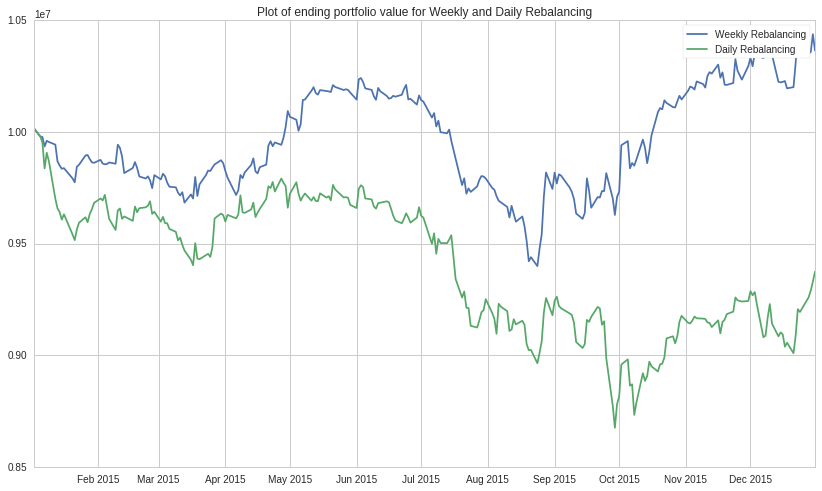

In [16]:
# Plotting ending portfolio value for weekly and daily rebalancing
plt.plot(week_start.daily_performance['ending_portfolio_value'], label = 'Weekly Rebalancing')
plt.plot(every_day.daily_performance['ending_portfolio_value'], label = 'Daily Rebalancing')
plt.title('Plot of ending portfolio value for Weekly and Daily Rebalancing')
plt.legend();

From the graph above, we can clearly see the benefits of rebalancing less often.  By subtracting the last two `ending portfolio values`, we can quantify the impact rebalancing too often has on our strategy.

In [17]:
# Difference 
difference = (week_start.daily_performance['ending_portfolio_value'][-1]) - \
             (every_day.daily_performance['ending_portfolio_value'][-1])
print 'Difference in portfolio values between weekly and daily rebalancing:', difference, '$'

# percentage difference
percentage_difference = difference * 100 / week_start.capital_base
print 'Percentage of base capital:', round(percentage_difference), '%'

Difference in portfolio values between weekly and daily rebalancing: 990448.360435 $
Percentage of base capital: 10.0 %


Changing the rebalancing period of our strategy leads to a 10% decrease in returns, eaten up by transaction costs. Optimizing the rebalance window is not solely motivated by increasing transaction costs however. Each strategy has it's innate optimal rebalance window, which should be found using economic rationale. We opt for using economic rationale as opposed to some optimization technique as it is far too easy to succumb to overfitting, discussed in another section. *Using quarterly rebalancing for a strategy that involved earning reports, or monthly rebalancing for a strategy that uses rolling monthly averages, or even daily rebalancing for a strategy that uses weather forecasting as a trading signal are good examples of 'innate' rebalancing periods.*

# Other things to look out for
While the practices mentioned in this notebook will help protect against, or help expose unwanted behaviors, being fully protected remains a challenging task. Here are a few more things to look out for when developing your signal.

- **Not using python exceptions which lead to unknown behaviors. **    
*An algorithm that uses a `try`/`except` loop can lead to unexpected behaviors in your algorithm as the loop will simply pass over an error. It is more beneficial in the long run for you to be aware of the error that is being brought up by the algorithm that to ignore it*. 
- **When possible, constructing a stateless algorithm is preferred**.   
*A stateless strategy is one that does not consider past performance to make future decisions. This is an advantage as it allows us to protect against data glitches and overfitting, not to mention it is easier in terms of computation. *
- **Using alternative datasets. **   
*Using alternative datasets helps hedging out against common risk factors. Synonymous with 'Drained Alpha Factor', a common risk factor is one that has already been priced into the market due to the large number of traders using it. You can protect against this by construct your strategies using alternative data available [here](https://www.quantopian.com/data), note that all datasets can be used for free over a certain time window. *

----

This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.